In [1]:
#import definitions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
#read in data
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

In [3]:
#define rgb colors for charts
purple = 0.459, 0.235, 0.745
gray = 0.827, 0.827, 0.827
black = 0.137, 0.122, 0.125

In [4]:
##various explores
#preview data
#wego.head()
#wego.info(verbose=True)

#### Cleaning & Derived Columns:

In [5]:
#drop rows with missing arrival or departure times
wego = wego.loc[(wego['ADJUSTED_ONTIME_COUNT'] == 1)
        |
        (wego['ADJUSTED_EARLY_COUNT'] == 1)
        |
        (wego['ADJUSTED_LATE_COUNT'] == 1)]

In [6]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return (row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

# create headway deviation percentage column
wego['HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [7]:
#establish columns for gapping, bunching, and acceptable headway values
wego['HDWY_GAPPING'] = 0
wego['HDWY_ACCEPTABLE'] = 0
wego['HDWY_BUNCHING'] = 0

In [8]:
#establish functions for populating headway columns
#Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 
#The generally accepted range of headway deviation is 50% to 150% of the scheduled headway 
#so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

def hdw_gapping(pct):
    if (pct > 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)
    
def hdw_acceptable(pct):
    if abs(pct) <= 50:
        return int(1)
    else:
        return int(0)
    
def hdw_bunching(pct):
    if (pct < 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)

In [9]:
#execute functions and apply 0/1 values to columns
wego['HDWY_BUNCHING'] = wego['HDWY_DEV_PCT'].apply(hdw_bunching)
wego['HDWY_ACCEPTABLE'] = wego['HDWY_DEV_PCT'].apply(hdw_acceptable)
wego['HDWY_GAPPING'] = wego['HDWY_DEV_PCT'].apply(hdw_gapping)

In [10]:
# #inspect new columns
#print(wego.HDWY_GAPPING.sum())
#print(wego.HDWY_ACCEPTABLE.sum())
#print(wego.HDWY_BUNCHING.sum())

In [11]:
#create a unique identifier
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [12]:
print('Number of distinct trips: ' + str(wego.DATE_TRIP.nunique()))

Number of distinct trips: 66450


#### About our data

In [13]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_GAPPING',
       'HDWY_ACCEPTABLE', 'HDWY_BUNCHING', 'DATE_TRIP'],
      dtype='object')

In [14]:
# date range start
wego.DATE.min()

'8/1/2023'

In [15]:
#date range end
wego.DATE.max()

'9/9/2023'

In [16]:
#number of routes
wego.ROUTE_ABBR.nunique()

8

In [17]:
#number of trips
wego.DATE_TRIP.nunique()

66450

In [18]:
#number of drivers
wego.OPERATOR.nunique()

341

In [19]:
#number of stops
len(wego)

338861

#### 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like? 

In [20]:
#overall on time performance
round(wego.ADJUSTED_ONTIME_COUNT.sum()/len(wego.ADJUSTED_ONTIME_COUNT)*100,2)

79.69

79.69% of trips are on time.

In [21]:
wego.ADJUSTED_EARLY_COUNT.sum() + wego.ADJUSTED_LATE_COUNT.sum() + wego.ADJUSTED_ONTIME_COUNT.sum()

338861

AttributeError: 'Axes' object has no attribute 'show'

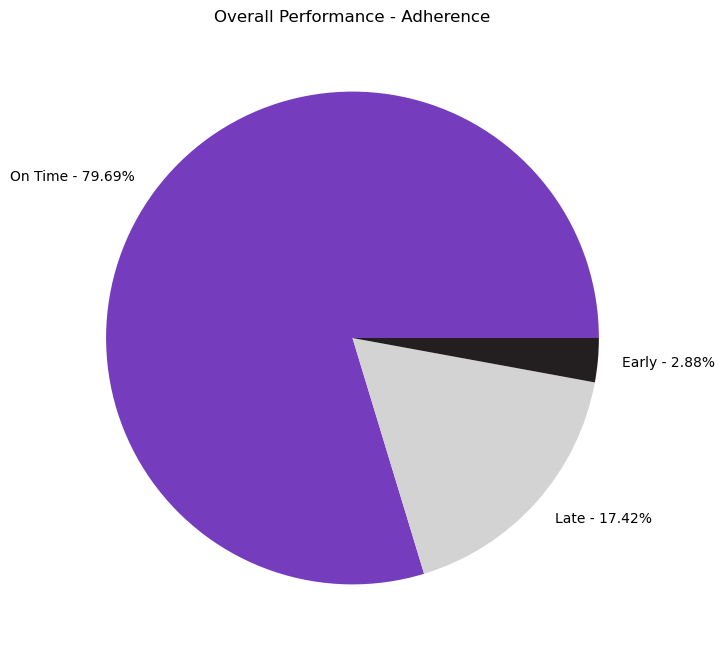

In [22]:
# Adherence graph - pie
# autopct='%1.2f%%'
pchart = wego[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().plot(kind='pie', colors=(purple, gray, black), labels=['On Time - 79.69%', 'Late - 17.42%', 'Early - 2.88%'], labeldistance=1.10, figsize=(10,8))
pchart.set (title = 'Overall Performance - Adherence')
plt.savefig('../images/overall_performance_pie.png')
pchart.show()

In [23]:
#perfect_trips
perfect_trips = wego.groupby('DATE_TRIP')[['ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']].sum()
perfect_trips = perfect_trips[(perfect_trips.ADJUSTED_EARLY_COUNT == 0) & (perfect_trips.ADJUSTED_LATE_COUNT == 0)]

perfect_count = len(perfect_trips)

percent_perfect = perfect_count/(wego.DATE_TRIP.nunique())*100

print('Number of perfect trips: ' + str(perfect_count))
print('Percentage of perfect trips: ' + str(percent_perfect))


Number of perfect trips: 39923
Percentage of perfect trips: 60.07975921745673


In [24]:
## Per Dibran - use adjusted fields and newly calculated hdwy to chart performance
#distribution of headway and adherence
ad_stddev = np.std(wego.ADHERENCE)
ad_mean = wego.ADHERENCE.mean()
ad_min = ad_mean-(ad_stddev*3)
ad_max = ad_mean+(ad_stddev*3)

hdw_stddev = np.std(wego.HDWY_DEV)
hdw_mean = wego.HDWY_DEV.mean()
hdw_min = hdw_mean-(hdw_stddev*3)
hdw_max = hdw_mean+(hdw_stddev*3)

In [25]:
# wego.ADHERENCE.describe()

In [26]:
# #distributions of adherence
# adherence_cats = wego[wego['ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT']].sum()
# # adherence_cats.plot(kind='hist')
# # adherence_cats.set(title='Adherence Distribution by Category', xlabel='Category',  ylabel='Count of Stops')
# sns.histplot(data=adherence_cats)

In [27]:
total_adh_count = len(wego.ADHERENCE)
adh_non_outlier = len(wego[wego['ADHERENCE'].between(ad_min, ad_max, inclusive='both')])
adh_outlier_count = total_adh_count - adh_non_outlier
print(adh_outlier_count)

total_hdw_count = len(wego.HDWY_DEV)
hdw_non_outlier = len(wego[wego['HDWY_DEV'].between(hdw_min, hdw_max, inclusive='both')])
hdw_outlier_count = total_hdw_count - hdw_non_outlier
print(hdw_outlier_count)



3341
76191


AttributeError: 'Axes' object has no attribute 'show'

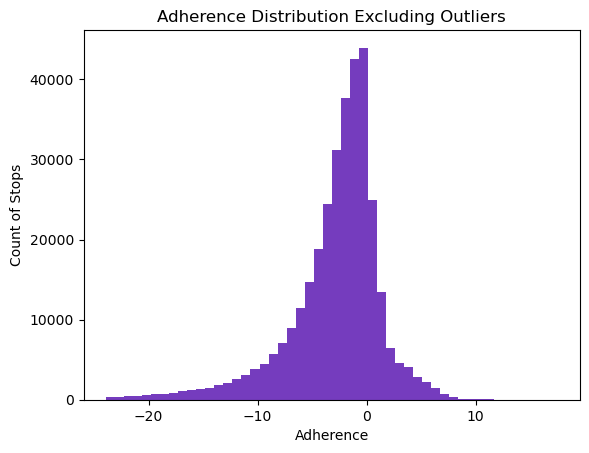

In [28]:
#distributions of adherence deviation
adherence_hist = wego[wego['ADHERENCE'].between(ad_min, ad_max, inclusive='both')]['ADHERENCE'].plot(kind='hist', bins=50, color = purple)
adherence_hist.set(title='Adherence Distribution Excluding Outliers', xlabel='Adherence',  ylabel='Count of Stops')
#plt.savefig('../images/ahderence_distribution.png')
adherence_hist.show()

In [29]:
wego.HDWY_DEV.describe()

count    265893.000000
mean          0.518081
std           7.161798
min         -64.000000
25%          -2.316667
50%           0.033333
75%           2.483333
max         565.433333
Name: HDWY_DEV, dtype: float64

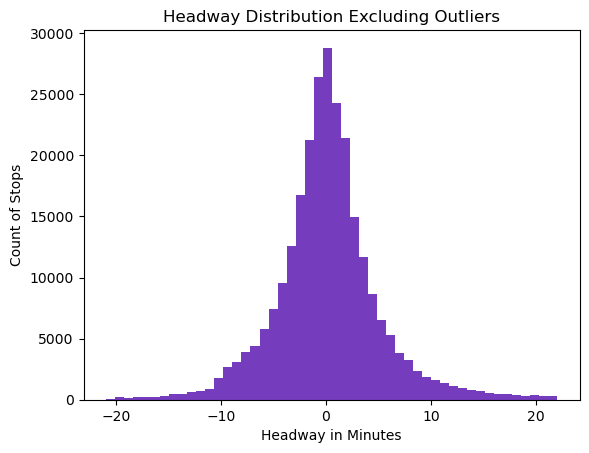

In [30]:
#distributions of headway deviation
adherence_hist = wego[wego['HDWY_DEV'].between(hdw_min, hdw_max, inclusive='both')]['HDWY_DEV'].plot(kind='hist', bins=50, color = purple)
adherence_hist.set(title='Headway Distribution Excluding Outliers', xlabel='Headway in Minutes',  ylabel='Count of Stops')
plt.savefig('../images/headway_distribution.png')
plt.show()

### 2. How does direction of travel, route, or location affect the headway and on-time performance?

#### Q2 Findings:
-- Buses headed into downtown are more timely than outbound buses </br>
-- Route 22 is the most timely </br>
-- 

In [31]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_GAPPING',
       'HDWY_ACCEPTABLE', 'HDWY_BUNCHING', 'DATE_TRIP'],
      dtype='object')

#### Direction

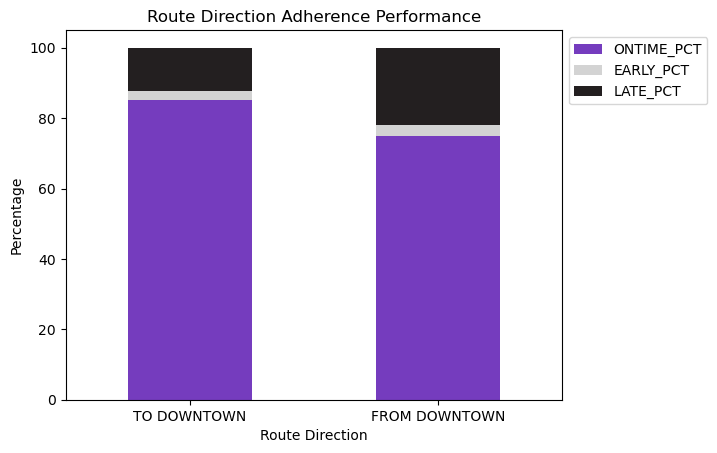

In [32]:
#ADHERENCE
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Direction Adherence Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/route_adherence.png')
plt.show()

In [33]:
routes_totals.head()

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT
ROUTE_DIRECTION_NAME,,,,,,,
FROM DOWNTOWN,134414,39601,5291,179306,74.963470,2.950822,22.085708
TO DOWNTOWN,135634,19437,4484,159555,85.007678,2.810316,12.182006


In [34]:
# #initial adherence by direction using count of stops
# #headyway and adherence by route direction
# ad_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().plot(kind='bar', stacked=True)
# ad_chart.set(title='Route Direction Adherence by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# ad_chart.legend(bbox_to_anchor=(1, 1))

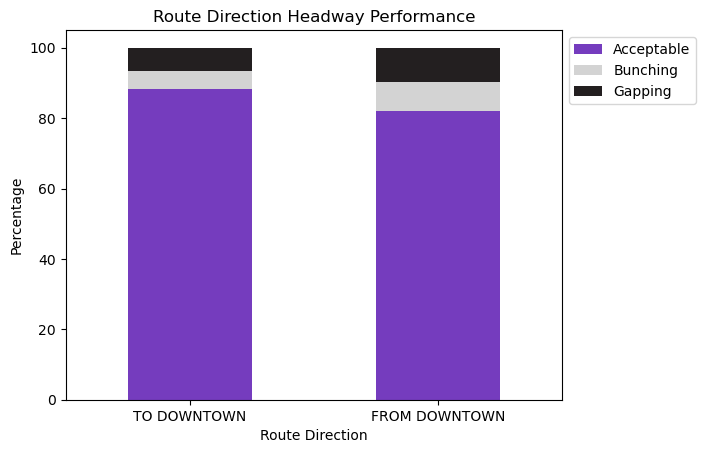

In [35]:
#HEADWAY
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Direction Headway Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), labels = ['Acceptable', 'Bunching', 'Gapping'])
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/route_headway.png')
plt.show()

In [36]:
# #initial headway by route direction using count of stops
# hdw_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().plot(kind='bar', stacked=True)
# hdw_chart.set(title='Route Direction Headway by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# hdw_chart.legend(bbox_to_anchor=(1, 1))


In [37]:
wego.groupby('ROUTE_DIRECTION_NAME')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_DIRECTION_NAME,,
FROM DOWNTOWN,-3.960287,0.579990
TO DOWNTOWN,-2.321804,0.447773


#### Route

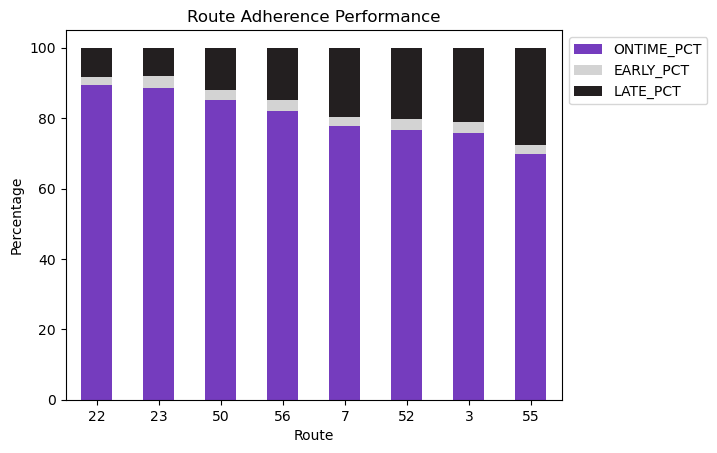

In [38]:
#break down stops by percentage of category
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/routeID_adherence.png')
plt.show()

In [39]:
# #initial adherence by route ID using count of stops
# #aherence by route ID
# rte_adh_chart = wego.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True)
# rte_adh_chart.set(title='Adherence by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_adh_chart.legend(bbox_to_anchor=(1, 1))

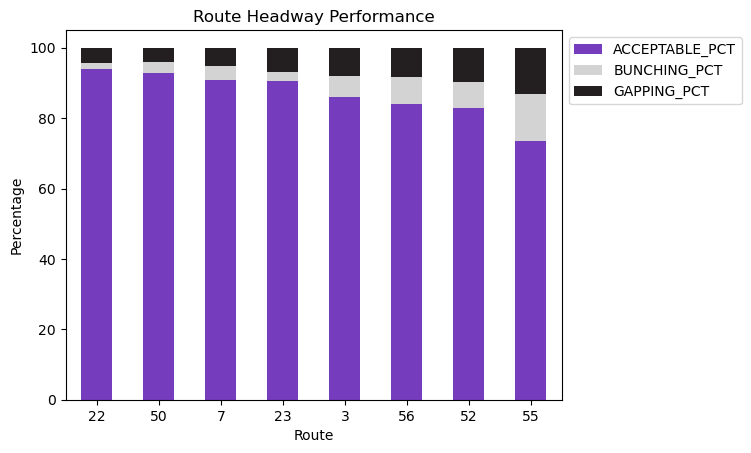

In [40]:
#break down stops by percentage of category - headway
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Headway Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/routeID_headway.png')
plt.show()

In [41]:
#intitial headway by route ID using count of stops
# #headway by route ID
# rte_hdw_chart = wego.groupby('ROUTE_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True)
# rte_hdw_chart.set(title='Headway by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [42]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


#### Stop location

In [43]:
wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False)

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
TIME_POINT_ABBR,,,
GXRVRGAT,11813,2355,495
DWMRT,11775,1267,237
WHBG,8868,2128,358
MCC4_18,8848,903,83
GXMADISO,8346,1169,287
...,...,...,...
CRES,28,4,0
MCC5_11,21,49,0
MCC4_13,19,3,48


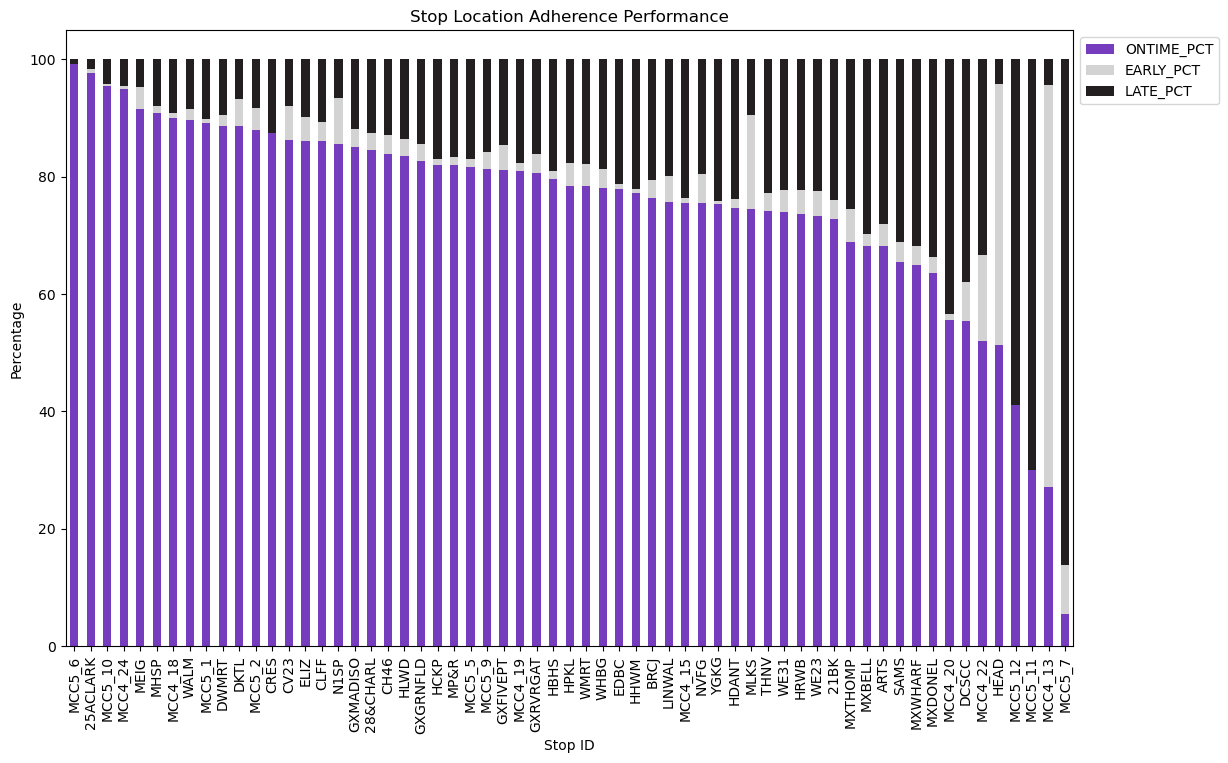

In [44]:
#break down stops by percentage of category
location_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

location_totals['TOTALS'] = location_totals.sum(axis=1)

location_totals['ONTIME_PCT'] = location_totals['ADJUSTED_ONTIME_COUNT'] / location_totals['TOTALS'] * 100
location_totals['EARLY_PCT'] = location_totals['ADJUSTED_EARLY_COUNT'] / location_totals['TOTALS'] * 100
location_totals['LATE_PCT'] = location_totals['ADJUSTED_LATE_COUNT'] / location_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    location_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, figsize=(13,8), color = (purple, gray, black))
ax.set(title = 'Stop Location Adherence Performance',
        xlabel = 'Stop ID',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=90)
#plt.savefig('../images/stopID_adherence.png')
plt.show()

In [45]:
# initial analysis - not adjusted for percentage
# #adherence by stop location
# #loc_adh_chart.figure(figsize=(12,12))
# loc_adh_chart = wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True, width=0.6, figsize=(13,8))
# loc_adh_chart.set(title='Adherence by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
# loc_adh_chart.legend(bbox_to_anchor=(1, 1))

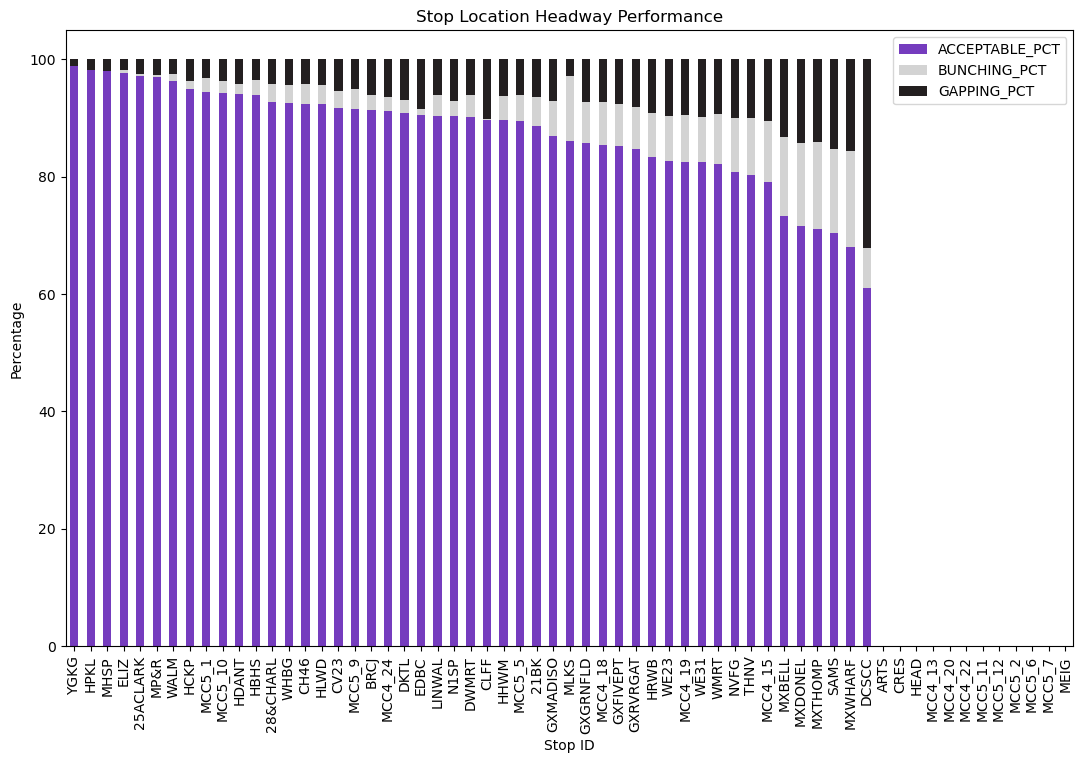

In [46]:
#break down stops by percentage of category - headway
location_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

location_totals['TOTALS'] = location_totals.sum(axis=1)

location_totals['ACCEPTABLE_PCT'] = location_totals['HDWY_ACCEPTABLE'] / location_totals['TOTALS'] * 100
location_totals['BUNCHING_PCT'] = location_totals['HDWY_BUNCHING'] / location_totals['TOTALS'] * 100
location_totals['GAPPING_PCT'] = location_totals['HDWY_GAPPING'] / location_totals['TOTALS'] * 100

# Stop ID Adherence graph
ax = (
    location_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, figsize=(13,8), color = (purple, gray, black))
ax.set(title = 'Stop Location Headway Performance',
        xlabel = 'Stop ID',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=90)
#plt.savefig('../images/stopID_headway.png')
plt.show()

In [47]:
# initial analysis - not adjusted for percentage
# #headway by stop location
# loc_hdw_chart = wego.groupby('TIME_POINT_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True, width=0.6, figsize=(13,8))
# loc_hdw_chart.set(title='Headway by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
# # loc_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [48]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('ADHERENCE', ascending=True)

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
MCC5_11,-37.570714,NaN
MCC4_20,-13.356229,NaN
MCC5_12,-9.785042,NaN
MCC5_7,-9.075463,NaN
DCSCC,-7.091481,12.054055
...,...,...
HEAD,1.013657,NaN
MCC5_2,1.252623,NaN
25ACLARK,1.458553,0.551163


### 3. How does time of day or day of week affect headway and on-time performance?

#### Time of Day

In [49]:
wego.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 338861 entries, 0 to 350328
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                338861 non-null  int64  
 1   SERVICE_ABBR               338861 non-null  int64  
 2   ADHERENCE_ID               338861 non-null  int64  
 3   DATE                       338861 non-null  object 
 4   ROUTE_ABBR                 338861 non-null  int64  
 5   BLOCK_ABBR                 338861 non-null  int64  
 6   OPERATOR                   338861 non-null  int64  
 7   TRIP_ID                    338861 non-null  int64  
 8   OVERLOAD_ID                338861 non-null  int64  
 9   ROUTE_DIRECTION_NAME       338861 non-null  object 
 10  TIME_POINT_ABBR            338861 non-null  object 
 11  ROUTE_STOP_SEQUENCE        338856 non-null  float64
 12  TRIP_EDGE                  338861 non-null  int64  
 13  LATITUDE                   338861 

In [50]:
#drop rows where there's no actual departure time values
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [51]:
# Create depart time column
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.hour)

In [52]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum())
hour_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
HOUR,,,
0,2898,1067,344
1,77,110,22
4,1591,16,90
5,9205,356,403
6,17110,1196,516
7,17790,3091,533
8,15816,4829,403
9,16885,2922,603
10,17172,2183,748


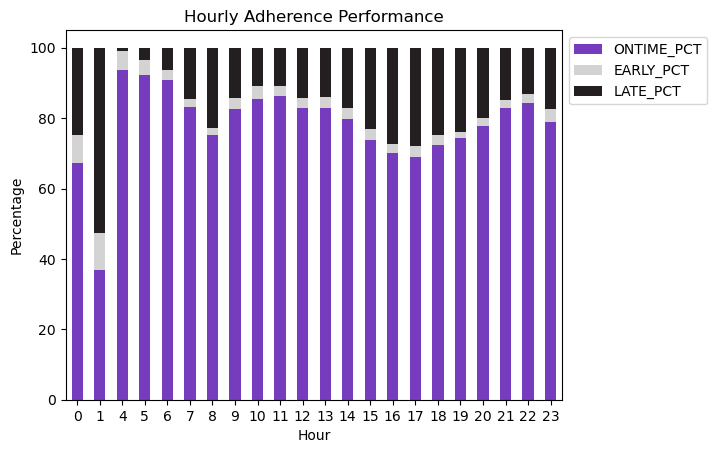

In [53]:
#ADHERENCE
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

hour_totals['TOTALS'] = hour_totals.sum(axis=1)

hour_totals['ONTIME_PCT'] = hour_totals['ADJUSTED_ONTIME_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals['EARLY_PCT'] = hour_totals['ADJUSTED_EARLY_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals['LATE_PCT'] = hour_totals['ADJUSTED_LATE_COUNT'] / hour_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    hour_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('HOUR', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Hourly Adherence Performance',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/hourly_adherence.png')
plt.show()

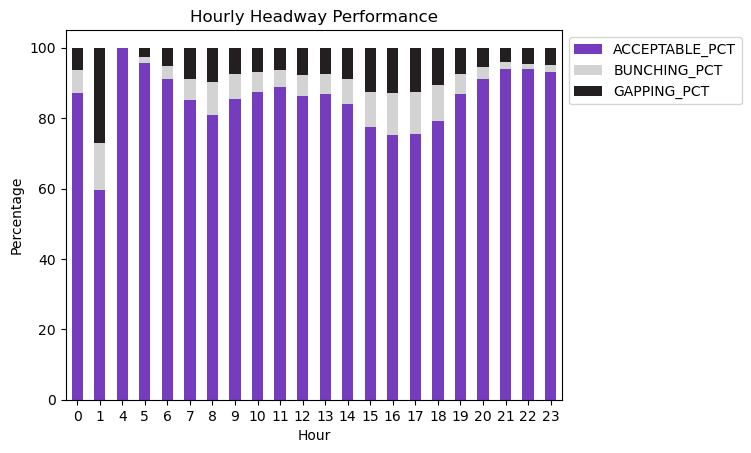

In [54]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

hour_totals['TOTALS'] = hour_totals.sum(axis=1)

hour_totals['ACCEPTABLE_PCT'] = hour_totals['HDWY_ACCEPTABLE'] / hour_totals['TOTALS'] * 100
hour_totals['BUNCHING_PCT'] = hour_totals['HDWY_BUNCHING'] / hour_totals['TOTALS'] * 100
hour_totals['GAPPING_PCT'] = hour_totals['HDWY_GAPPING'] / hour_totals['TOTALS'] * 100

# Hour Headway graph
ax = (
    hour_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('HOUR', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Hourly Headway Performance',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/hourly_headway.png')
plt.show()

#### By day of week

In [55]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

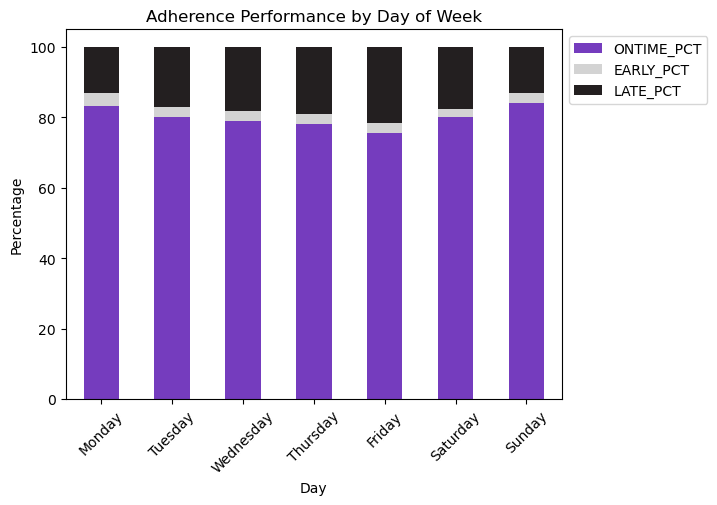

In [56]:
#ADHERENCE
day_totals = (
    clean_dept_time.groupby('WEEKDAY')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

day_totals['TOTALS'] = day_totals.sum(axis=1)

day_totals['ONTIME_PCT'] = day_totals['ADJUSTED_ONTIME_COUNT'] / day_totals['TOTALS'] * 100
day_totals['EARLY_PCT'] = day_totals['ADJUSTED_EARLY_COUNT'] / day_totals['TOTALS'] * 100
day_totals['LATE_PCT'] = day_totals['ADJUSTED_LATE_COUNT'] / day_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    day_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('WEEKDAY', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Adherence Performance by Day of Week',
        xlabel = 'Day',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)
plt.savefig('../images/dayofweek_adherence.png')
plt.show()

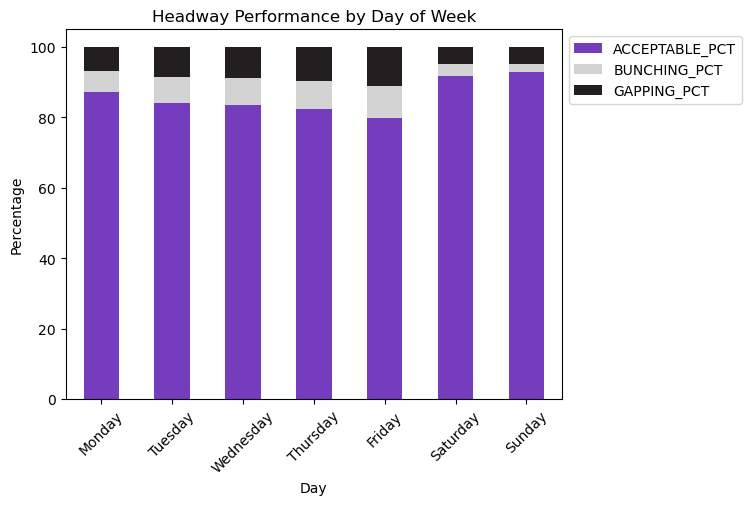

In [57]:
#HEADWAY
day_totals = (
    clean_dept_time.groupby('WEEKDAY')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

day_totals['TOTALS'] = day_totals.sum(axis=1)

day_totals['ACCEPTABLE_PCT'] = day_totals['HDWY_ACCEPTABLE'] / day_totals['TOTALS'] * 100
day_totals['BUNCHING_PCT'] = day_totals['HDWY_BUNCHING'] / day_totals['TOTALS'] * 100
day_totals['GAPPING_PCT'] = day_totals['HDWY_GAPPING'] / day_totals['TOTALS'] * 100

# Hour Headway graph
ax = (
    day_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('WEEKDAY', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Headway Performance by Day of Week',
        xlabel = 'Day',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)
plt.savefig('../images/dayofweek_headway.png')
plt.show()

In [58]:
# grouper dt conversion to redo hourly groupings
# clean_dept_time['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'])

##### 4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

#### number 4 - group by operator, what percent of stops are acceptable vs total stops

#### drivers along individual routes

In [59]:
#### number 4 - group by operator, what percent of stops are acceptable vs total stops

In [60]:
# wego.OPERATOR.nunique()

In [61]:
wego.groupby('OPERATOR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum()

,HDWY_ACCEPTABLE,HDWY_BUNCHING,HDWY_GAPPING,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
OPERATOR,,,,,,
0,0,0,0,0,0,1
56,2,0,0,0,0,3
235,7,0,2,1,5,6
244,13,3,4,0,5,20
301,16,4,10,1,17,19
...,...,...,...,...,...,...
3149,52,0,4,4,8,76
3156,220,5,5,0,71,219
3165,16,0,8,0,20,12


In [62]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_GAPPING,HDWY_ACCEPTABLE,HDWY_BUNCHING,DATE_TRIP
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,6.500000,NaN,NaN,0,0,0,120230801-345104
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,NaN,0,0,0,120230801-345104
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,NaN,0,0,0,120230801-345104
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,0,NaN,0,0.000000,NaN,NaN,0,0,0,120230801-345104
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,0.0,0,12.866666,5.0,NaN,0,0,0,120230801-345105


In [63]:
#HEADWAY
operator_totals = (
    wego.groupby('OPERATOR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']]
         .sum()
)

operator_totals['ADHERENCE_TOTALS'] = operator_totals[['ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum(axis=1)
operator_totals['HEADWAY_TOTALS'] = operator_totals[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum(axis=1)

operator_totals['ACCEPTABLE_ADHERENCE_PCT'] = operator_totals['ADJUSTED_ONTIME_COUNT'] / operator_totals['ADHERENCE_TOTALS'] * 100
operator_totals['ACCEPTABLE_HEADWAY_PCT'] = operator_totals['HDWY_ACCEPTABLE'] / operator_totals['HEADWAY_TOTALS'] * 100



In [64]:
op_summary = operator_totals[['ADHERENCE_TOTALS', 'ACCEPTABLE_ADHERENCE_PCT', 'HEADWAY_TOTALS', 'ACCEPTABLE_HEADWAY_PCT']].sort_values('ACCEPTABLE_ADHERENCE_PCT', ascending=False)
op_summary

,ADHERENCE_TOTALS,ACCEPTABLE_ADHERENCE_PCT,HEADWAY_TOTALS,ACCEPTABLE_HEADWAY_PCT
OPERATOR,,,,
0,1,100.000000,0,NaN
56,3,100.000000,2,100.000000
2294,45,100.000000,28,100.000000
1762,2333,98.328333,1553,91.435930
1706,44,97.727273,37,86.486486
...,...,...,...,...
2094,38,23.684211,32,46.875000
1377,60,20.000000,0,NaN
2982,28,7.142857,19,31.578947


In [65]:
top20_adh = (op_summary[op_summary['ADHERENCE_TOTALS'] >= 1000]
            .nlargest(20, columns=['ACCEPTABLE_ADHERENCE_PCT', 'ADHERENCE_TOTALS']))

In [66]:
bottom20_adh = (op_summary[op_summary['ADHERENCE_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ACCEPTABLE_ADHERENCE_PCT', 'ADHERENCE_TOTALS']))

In [67]:
top20_hdw = (op_summary[op_summary['HEADWAY_TOTALS'] >= 1000]
            .nlargest(20, columns=['ACCEPTABLE_HEADWAY_PCT', 'HEADWAY_TOTALS']))

In [68]:
bottom20_hdw = (op_summary[op_summary['HEADWAY_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ACCEPTABLE_HEADWAY_PCT', 'HEADWAY_TOTALS']))

In [69]:
# join TOP dfs on operator
top_operators = (pd.merge(top20_adh, 
                          top20_hdw[[]], 
                          how='inner', 
                          left_index=True, 
                          right_index=True))
top_operators

,ADHERENCE_TOTALS,ACCEPTABLE_ADHERENCE_PCT,HEADWAY_TOTALS,ACCEPTABLE_HEADWAY_PCT
OPERATOR,,,,
1762,2333,98.328333,1553,91.435930
409,2380,97.058824,1715,96.618076
1566,2200,97.045455,1835,98.038147
1927,2413,96.021550,1960,95.357143
1040,1770,95.762712,1058,97.353497
1133,2625,95.428571,2177,93.615067
1617,1806,95.293466,1281,97.189696
2321,1420,94.014085,1180,93.728814
2041,1548,92.829457,1187,93.344566


In [70]:
# join BOTTOM dfs on operator
bottom_operators = (pd.merge(bottom20_adh, 
                             bottom20_hdw[[]], 
                             how='inner', 
                             left_index=True, 
                             right_index=True))
bottom_operators

,ADHERENCE_TOTALS,ACCEPTABLE_ADHERENCE_PCT,HEADWAY_TOTALS,ACCEPTABLE_HEADWAY_PCT
OPERATOR,,,,
3101,1297,44.641480,1055,72.985782
1800,1625,48.553846,1298,73.805855
2109,2093,54.419494,1707,68.775630
357,1584,54.671717,1204,75.581395
1352,1693,56.349675,1412,63.526912
1277,1375,57.818182,1075,74.790698
2356,1408,58.238636,1105,69.049774
2082,1759,58.442297,1460,70.821918
1359,1548,59.560724,1289,65.399535


In [71]:
top_bottom_operators = pd.concat([top_operators, bottom_operators.sort_values('ACCEPTABLE_ADHERENCE_PCT', ascending=False)])
top_bottom_operators

,ADHERENCE_TOTALS,ACCEPTABLE_ADHERENCE_PCT,HEADWAY_TOTALS,ACCEPTABLE_HEADWAY_PCT
OPERATOR,,,,
1762,2333,98.328333,1553,91.435930
409,2380,97.058824,1715,96.618076
1566,2200,97.045455,1835,98.038147
1927,2413,96.021550,1960,95.357143
1040,1770,95.762712,1058,97.353497
1133,2625,95.428571,2177,93.615067
1617,1806,95.293466,1281,97.189696
2321,1420,94.014085,1180,93.728814
2041,1548,92.829457,1187,93.344566


In [72]:
# Creat new column for negative Headway
top_bottom_operators.loc[:, 'NEGATIVE_ACCEPTABLE'] = top_bottom_operators['ACCEPTABLE_ADHERENCE_PCT'].apply(lambda pct: -pct)

In [73]:
# function to correct negative 
def get_label_value(num):
    if num >= 0:
        return str(round((num), 2)) + '%'
    else:
        return str(round((-num), 2)) +'%'

C:\Users\hayle\AppData\Local\Temp\ipykernel_65388\2756347677.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])


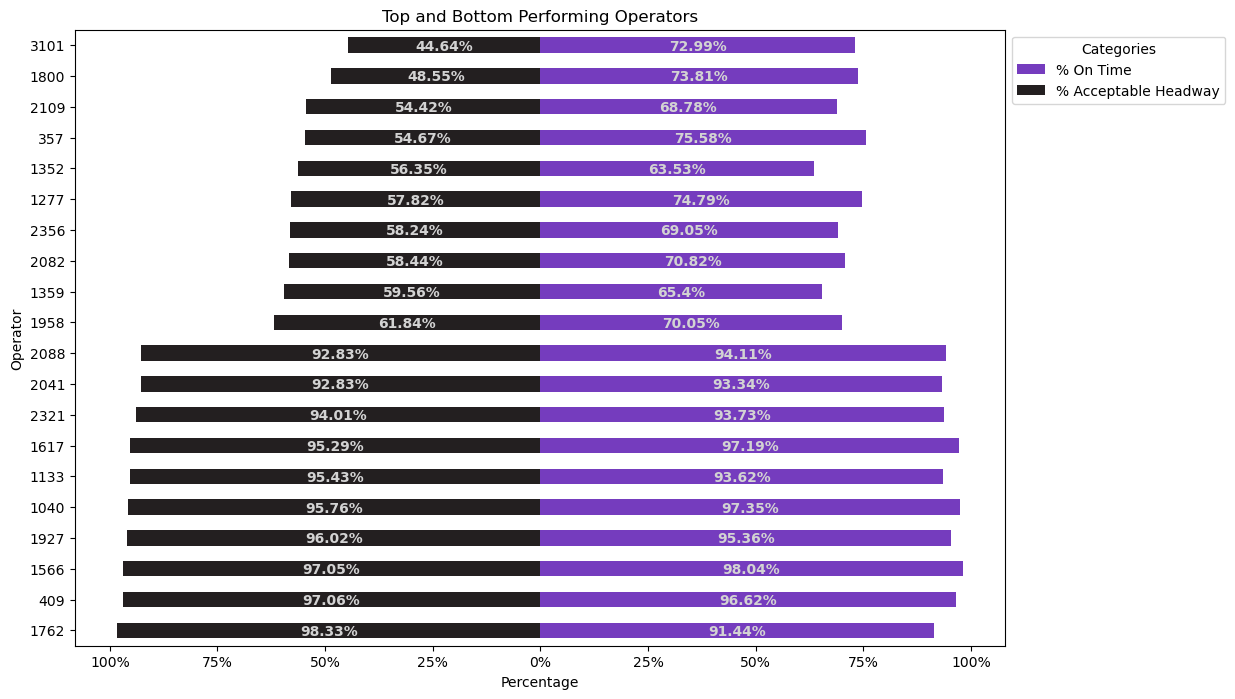

In [74]:
# Graph Top and Bottom Operators
ax = top_bottom_operators[['ACCEPTABLE_HEADWAY_PCT', 'NEGATIVE_ACCEPTABLE']].plot(kind='barh',
                                                                      stacked=True,
                                                                      figsize=(12, 8),
                                                                     color= [purple, black])

ax.set(title = 'Top and Bottom Performing Operators',
        xlabel = 'Percentage',
       ylabel = 'Operator')

# set bar labels
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2, # horizontal alignment
      bar.get_height() + bar.get_y() - 0.41, # vertical alignment
      get_label_value(bar.get_width()), # value
      ha='center', # Center the labels
      color= gray, # style labels
      weight='bold',
      size=10
  )

ax.legend(bbox_to_anchor=(1, 1), title='Categories', labels = ['% On Time', '% Acceptable Headway'])
# Create custom percent labels
ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])

#plt.savefig('../images/top_and_bottom_opperators_graph.png')
plt.show()

In [82]:
sample_ops_id = top_bottom_operators.index.tolist()

sample_ops = wego[wego.OPERATOR.isin(sample_ops_id)]

sample_ops = (
    sample_ops.groupby(['OPERATOR','ROUTE_ABBR'])
         [['HDWY_ACCEPTABLE','ADJUSTED_ONTIME_COUNT']]
         .mean())

In [83]:
sample_ops

HDWY_ACCEPTABLE  ADJUSTED_ONTIME_COUNT
OPERATOR ROUTE_ABBR                                        
357      3                  0.638554               0.566265
         7                  0.554054               0.716216
         22                 0.617391               0.713043
         23                 0.592000               0.720000
         50                 0.660377               0.466981
         52                 0.483516               0.307692
         55                 0.521898               0.598540
         56                 0.479365               0.498413
409      23                 0.696218               0.970588
1040     22                 0.581921               0.957627
1133     50                 0.776381               0.954286
1277     3                  0.559701               0.738806
         7                  0.547826               0.591304
         22                 0.480392               0.764706
         50                 0.717742               0.782258
         52                 0.598039               0.607843
         55                 0.561404               0.418546
         56                 0.609023               0.561404
1352     55                 0.529829               0.563497
1359     55                 0.544574               0.595607
1566     50                 0.817727               0.970455
1617     7                  0.545455               0.930736
         22                 0.710476               0.956190
1762     22                 0.608658               0.983283
1800     52                 0.589538               0.485538
1927     23                 0.716937               0.995360
         50                 0.788551               0.955647
         56                 0.720930               0.813953
1958     55                 0.565432               0.606584
         56                 0.655556               0.777778
2041     23                 0.694501               0.954175
         52                 0.756661               0.884547
         55                 0.000000               0.666667
2082     55                 0.587834               0.584423
2088     22                 0.671202               0.975057
         23                 0.683491               0.941115
         52                 0.767442               0.810078
         56                 0.792453               0.921833
2109     7                  0.608696               0.683230
         50                 0.648282               0.616637
         52                 0.578947               0.578947
         55                 0.437103               0.411690
         56                 0.200000               0.600000
2321     50                 0.778873               0.940141
2356     52                 0.596192               0.661323
         55                 0.409756               0.390244
3101     3                  0.646753               0.511688
         7                  0.500000               0.166667
         50                 0.833333               1.000000
         52                 0.560414               0.395857
         56                 0.857143               1.000000

5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

C:\Users\hayle\AppData\Local\Temp\ipykernel_65388\3726205598.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(wego['ADHERENCE'],


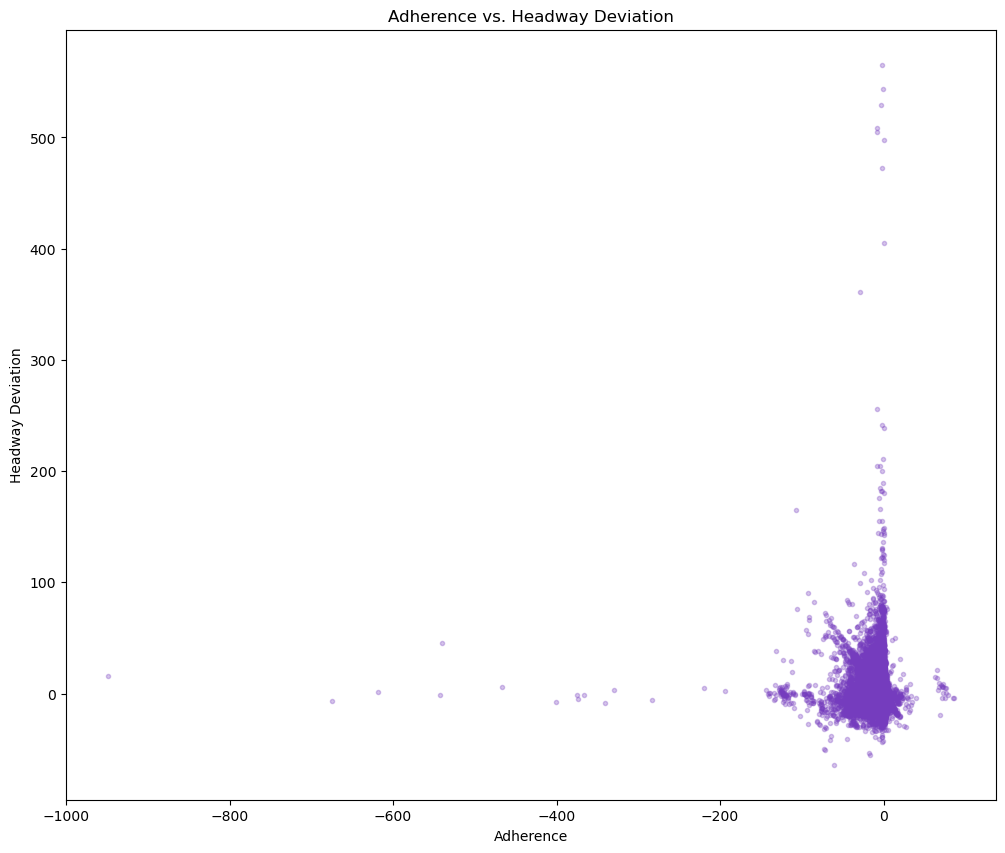

In [89]:
# PLOT Adherence vs Headway Deviation
plt.figure(figsize=(12,10))
plt.scatter(wego['ADHERENCE'],
            wego['HDWY_DEV'],
           c= purple,
           marker='.',
           alpha=0.3)

plt.title('Adherence vs. Headway Deviation')
plt.xlabel('Adherence')
plt.ylabel('Headway Deviation')

plt.savefig('../images/adherence_headway_corr.png')
plt.show()

In [90]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_GAPPING',
       'HDWY_ACCEPTABLE', 'HDWY_BUNCHING', 'DATE_TRIP'],
      dtype='object')

In [91]:
#correlation
wego[['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.206794
HDWY_DEV,-0.206794,1.000000


In [92]:
# early correlation
wego[wego['ADJUSTED_EARLY_COUNT'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.030098
HDWY_DEV,-0.030098,1.000000


In [93]:
# on time correlation
wego[wego['ADJUSTED_ONTIME_COUNT'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.225793
HDWY_DEV,-0.225793,1.000000


In [94]:
# late correlation
wego[wego['ADJUSTED_LATE_COUNT'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.018835
HDWY_DEV,-0.018835,1.000000


In [95]:
'HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING'

('HDWY_ACCEPTABLE', 'HDWY_BUNCHING', 'HDWY_GAPPING')

In [96]:
wego[wego['HDWY_ACCEPTABLE'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.286277
HDWY_DEV,-0.286277,1.000000


In [97]:
wego[wego['HDWY_BUNCHING'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,0.193366
HDWY_DEV,0.193366,1.000000


In [98]:
wego[wego['HDWY_GAPPING'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.047904
HDWY_DEV,-0.047904,1.000000



**Stretch Goals:**  

6. How much impact does being late or too spaced out at the first stop have downstream?  
7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more dwell time at the beginning of a trip lead to more stable headways (lower values for % headway deviation)? Do trips with longer **scheduled** layover time have more stable headway values?  
8. What is the relationship between distance or time traveled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has traveled?